In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
cases_state = pd.read_csv('./data/cases_state.csv', index_col=0)
cases_state_pivoted = cases_state.pivot(index='date', columns='state', values='cases_new')

deaths_state = pd.read_csv('./data/deaths_state.csv')
deaths_state_pivoted = deaths_state.pivot(index='date', columns='state', values='deaths_new')

tests_state = pd.read_csv('./data/tests_state.csv')
tests_state_pivoted = tests_state.pivot(index='date', columns='state', values='total')

quarantine_state = pd.read_csv('./data/pkrc.csv')
quarantine_state_pivoted = quarantine_state.pivot(index='date', columns='state', values='admitted_covid')
discharge_quarantine_state_pivoted = quarantine_state.pivot(index='date', columns='state', values='discharge_covid')

icu_state = pd.read_csv('./data/icu.csv')
icu_state_pivoted = icu_state.pivot(index='date', columns='state', values='icu_covid')

hospital = pd.read_csv('./data/hospital.csv')
hospital_admitted_pivoted = hospital.pivot(index='date', columns='state', values='admitted_covid')
hospital_discharged_pivoted = hospital.pivot(index='date', columns='state', values='discharged_covid')

population_state = pd.read_csv('./data/population.csv', index_col=0)
cases_state.head()

,date,state,cases_import,cases_new,cases_recovered
0,2020-01-25,Johor,4,4,0
1,2020-01-25,Kedah,0,0,0
2,2020-01-25,Kelantan,0,0,0
3,2020-01-25,Melaka,0,0,0
4,2020-01-25,Negeri Sembilan,0,0,0


In [3]:
states_list = ['Pahang', 'Kedah', 'Johor', 'Selangor']
states = {}

for state in states_list:
    df = pd.DataFrame()
    df['cases'] = cases_state_pivoted[state]
    df['deaths'] = deaths_state_pivoted[state]
    df['tests'] = tests_state_pivoted[state]
    df['quarantine'] = quarantine_state_pivoted[state]
    df['discharge_quarantine'] = discharge_quarantine_state_pivoted[state]
    df['icu'] = icu_state_pivoted[state]
    df['hospital_admitted'] = hospital_admitted_pivoted[state]
    df['hospital_discharged'] = hospital_discharged_pivoted[state]
    df.fillna(0, inplace=True)
    states[state] = df

## Finding Best Features

Techniques Used:
1. Variance Threshold
2. SelectKBest with Mutual Info Regression
3. SelectKBest with Chi-Squared
4. Recursive Feature Elimination

In [35]:
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_regression, RFE, VarianceThreshold
from sklearn.linear_model import LinearRegression

def get_best_features(df):
    X = df.drop(['cases'], axis=1)
    y = df['cases']

    selector = VarianceThreshold(3)
    selector.fit(df)
    variance_best = df.columns[selector.get_support()]

    selector = SelectKBest(mutual_info_regression, k=4)
    selector.fit(X, y)
    mutual_info_best = X.columns[selector.get_support()]

    selector = SelectKBest(chi2, k=4)
    selector.fit(X, y)
    chi2_best = X.columns[selector.get_support()]

    rfe_selector = RFE(LinearRegression(), n_features_to_select=4)
    rfe_selector.fit(X, y)
    rfe_best = X.columns[rfe_selector.get_support()]

    columns = df.columns
    columns_count = {}
    for column in columns:
        columns_count[column] = list(variance_best).count(column) + list(mutual_info_best).count(column) + list(chi2_best).count(column) + list(rfe_best).count(column)
    
    best_features = sorted(columns_count, key=columns_count.get)[-4:]

    for num in range(len(best_features) - 1):
        x = num + 1
        for num2 in range(len(best_features) - num - 1):
            sns.scatterplot(x= best_features[num], y=best_features[x], data=df)
            plt.xlabel('Features')
            plt.ylabel('Cases')
            x = x + 1

    if 'tests' not in best_features:
        best_features.append('tests')

    return best_features

['quarantine', 'discharge_quarantine', 'icu', 'hospital_admitted', 'tests']

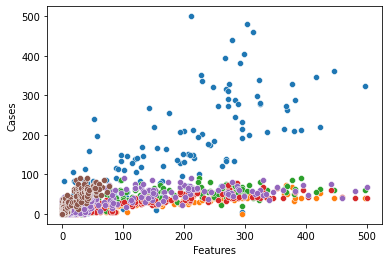

In [36]:
get_best_features(states['Pahang'])

## Modeling
Classification:
1. Support Vector Machine
2. Decision Tree
3. Random Forest Classifier

Regression:
1. Support Vector Machine
2. Linear Regression
3. Random Forest Regressor

In [6]:
from sklearn.svm import SVR, SVC
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

## Regression

In [9]:
def svm_regression(df, features):
    X = df[features]
    y = df['cases']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

    svr_rbf = SVR(kernel='rbf', C=1e5, gamma=0.001)
    svr_rbf.fit(X_train, y_train)
    svr_rbf_pred = svr_rbf.predict(X_test)

    svr_rbf_score = svr_rbf.score(X_test, y_test)

    print('SVR RBF Score: ', svr_rbf_score)

In [19]:
def linear_regression(df, features):
    X = df[features]
    y = df['cases']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

    lin_reg = LinearRegression()
    lin_reg.fit(X_train, y_train)
    lin_reg_pred = lin_reg.predict(X_test)

    lin_reg_score = lin_reg.score(X_test, y_test)

    print('Linear Regression Score: ', lin_reg_score)

In [21]:
def random_forest_regressor(df, features):
    X = df[features]
    y = df['cases']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

    rf_reg = RandomForestRegressor(n_estimators=10, random_state=42)
    rf_reg.fit(X_train, y_train)
    rf_reg_pred = rf_reg.predict(X_test)

    rf_reg_score = rf_reg.score(X_test, y_test)

    print('Random Forest Regressor Score: ', rf_reg_score)

SVR RBF Score:  0.750470119296011
Linear Regression Score:  0.8269142563006484
Random Forest Regressor Score:  0.8831368193309622


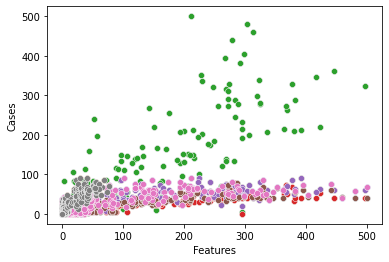

In [22]:
svm_regression(states['Pahang'], get_best_features(states['Pahang']) + ['tests'])
linear_regression(states['Pahang'], get_best_features(states['Pahang']) + ['tests'])
random_forest_regressor(states['Pahang'], get_best_features(states['Pahang']) + ['tests'])

## Classification

In [ ]:
def svm_classification():
    